In [119]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al 
from meep.materials import Al2O3  

In [120]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 100             # 추출할 주파수 개수
design_region_resolution = 50

In [121]:
tal = 1
talq3 = 0.5
tsio2 = 2

tair_near = 3.5
tair_far = 6

tpml = 0.5

tmetal_boundary = 1


design_region_width = 5       # OLED의 가로/세로 길이
design_region_height = 1
metal_boundary_height = tal+talq3+design_region_height+tsio2

al = Al

metal_boundary = mp.Medium(index=1.58)

alq3 = mp.Medium(index = 1.68)
sio2 = mp.Medium(index = 2.1)
SiN = mp.Medium(index = 1.8)
air = mp.Medium(index = 1)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

boundary_layers = [mp.PML(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]



In [122]:
Sy = tal+talq3+design_region_height+tsio2+tair_near+tpml
Sx = tpml+tmetal_boundary + design_region_width + tmetal_boundary + tpml   # x 방향 전체 크기 (design_region_width=6)

# --- 3. y축 아래쪽(bottom) 좌표 계산 ---
y_bottom = -Sy/2  # 전체 셀의 맨 바닥 y값

# --- 4. 층별 센터 y 좌표 계산 (아래에서 위로) ---
# 1) Al
center_y_al = y_bottom + tal / 2

# 2) Alq3
center_y_alq3 = y_bottom + tal + talq3 / 2

# 3) Design Region (SiN↔SiO2 중간)
center_y_design = y_bottom + tal + talq3 + design_region_height / 2

# 4) SiO2
center_y_sio2 = y_bottom + tal + talq3 + design_region_height + tsio2 / 2

# 5) Air (맨 위)
center_y_air = y_bottom + tal + talq3 + design_region_height + tsio2 + tair_near / 2

# --- 5. Al₂O₃(측면) 블록 높이 및 y 중심 좌표 ---
metal_boundary_height = talq3 + design_region_height + tsio2
center_y_metal_boundary = y_bottom + metal_boundary_height / 2

# --- 6. Al₂O₃(측면) 블록 x 중심 좌표 계산 ---
x_left_metal_boundary  = - (design_region_width/2 + tmetal_boundary/2)
x_right_metal_boundary = + (design_region_width/2 + tmetal_boundary/2)

tpml          = 0.5


cell_size = mp.Vector3(Sx, Sy)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), sio2,SiN,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0,center_y_design,0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    # ───────────────────────────────────────────────
    # 1) Al 층 (맨 아래)
    mp.Block(
        material=al,
        size=mp.Vector3(mp.inf, tal, design_region_width),
        center=mp.Vector3(0, center_y_al, 0)
    ),

    # 2) Alq3 층
    mp.Block(
        material=alq3,
        size=mp.Vector3(design_region_width, talq3, design_region_width),
        center=mp.Vector3(0, center_y_alq3, 0)
    ),

    # 3) Design Region (SiN ↔ SiO₂)
    mp.Block(
        material=design_variables,                  # MaterialGrid로 정의된 design region
        size=mp.Vector3(design_region_width, design_region_height, design_region_width),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    # 4) SiO₂ 층
    mp.Block(
        material=sio2,
        size=mp.Vector3(design_region_width, tsio2, design_region_width),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),

    ##################### metal_boundary 좌측 #####################
    # sio2
    mp.Block(
        material=sio2,
        size=mp.Vector3(0.5, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            - (design_region_width/2 + tmetal_boundary/2-0.25),
            -1.5,
            0
        )
    ),
    # Al2O3
    mp.Block(
        material=metal_boundary,
        size=mp.Vector3(2, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            - (design_region_width/2 + tmetal_boundary/2+1),
            -1.5,
            0
        )
    ),

    # ##################### metal_boundary 우측 #####################
    # sio2
    mp.Block(
        material=sio2,
        size=mp.Vector3(0.5, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            + (design_region_width/2 + tmetal_boundary/2-0.25),
            -1.5,
            0
        )
    ),

    # al2o3
    mp.Block(
        material=metal_boundary,
        size=mp.Vector3(2, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            + (design_region_width/2 + tmetal_boundary/2+1),
            -1.5,
            0
        )
    ),
]


In [333]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
n_dipole=5

for i in range(n_dipole):
    # x: 디자인 영역 너비를 (i+1)/(n_dipole+1) 비율로 분할
    x_i = -design_region_width/2 + design_region_width * ((i+1) / (n_dipole+1))
    
    sources.append(
        mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                x_i,
                center_y_alq3,  # Alq3 층의 중간 높이
                0
            )
        )
    )

# --- 2. Simulation 객체 생성: 각 Source당 하나씩 시뮬레이션 인스턴스 생성 ---
sim = []
for i in range(n_dipole):
    sim.append(
        mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=boundary_layers,
            geometry=geometry,
            sources=[sources[i]],
            default_material=air,
            extra_materials=[al, metal_boundary],  # 필요에 따라 추가 물질
        )
    )

In [334]:
n_dipole=5

In [336]:
for i in range(n_dipole):    
    dft_fields_size = tmetal_boundary+design_region_width+tmetal_boundary

    dft_fields = sim[i].add_dft_fields([mp.Ez], fcen, 0, 1, 
                                    center = mp.Vector3(0, center_y_sio2+tsio2/2+1/fcen),
                                    size = mp.Vector3(dft_fields_size,0,0), 
                                    yee_gri=True)

    offset = 0.01
    flux_size = 0.02

    total_flux = sim[i].add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources[i].center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources[i].center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources[i].center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources[i].center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )


<Axes: xlabel='X', ylabel='Y'>

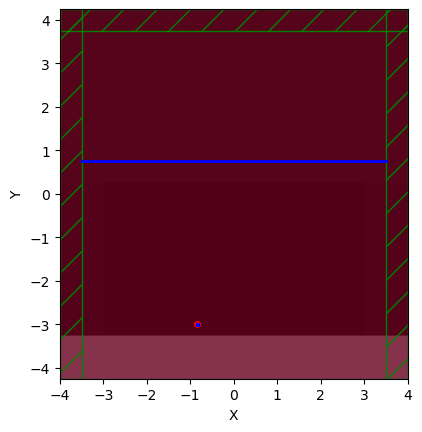

In [339]:
# sim[n_dipole].reset_meep()
# sim[n_dipole].run(until=1)
sim[1].plot2D(fields = mp.Ez)#output_plane = mp.Volume(center = sources[n_dipole].center, size = mp.Vector3(0.75,0.75)))
    # output_plane = mp.Volume(
    #               center = mp.Vector3(0, Sy/2 - (tair + tsio2 + design_region_height + tito + tandp + talq3/2)), 
    #                 size = mp.Vector3(2,2)))    

In [341]:
tol = 1e-3

for i in range(n_dipole):
    sim[i].run(
        mp.dft_ldos(fcen,0,1),
        until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources[i].center, tol),
    )

In [342]:
dA = 1 / (resolution**2)

ldos_total_flux = -np.real(sim[0].ldos_Fdata[0] * np.conj(sim[0].ldos_Jdata[0])) *dA
ldos_total_flux

0.5966364296279371

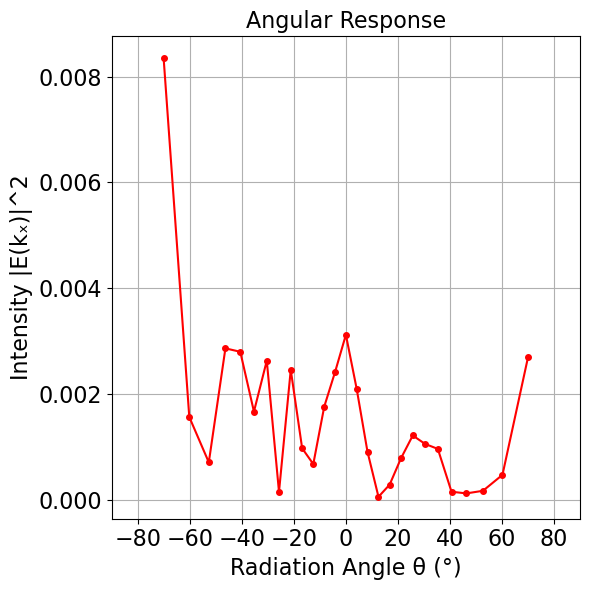

In [344]:
dft_fields_Ez = sim[n_dipole-1].get_dft_array(dft_fields, mp.Ez, 0)

N = len(dft_fields_Ez)
dx = 1.0 / resolution       # (unit length 당 샘플링 간격)
k0 = 2 * np.pi * fcen       # (rad per unit length)

E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N    # shape = (N,)

# (2-2) “cycle per unit length” 단위의 x축 빈도 (shape = (N,))
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# (2-3) rad per unit length → kx 값
kx = 2 * np.pi * kx_cycles    # shape = (N,)

mask = np.abs(kx) <= k0      # k0보다 작은 것들은 evanescent mode로 분류
kx_prop = kx[mask]           # shape = (M,), M <= N

ky_prop = np.sqrt(np.maximum(k0**2 - kx_prop**2, 0.0))   # shape = (M,)

theta = np.arcsin(kx_prop / k0)      # radians
theta_deg = np.degrees(theta)       # degrees

amplitude = np.abs(E_k)              # shape = (N,)
amplitude_prop = amplitude[mask]**2     # 전파 가능 성분만 (shape = (M,))

font_label = 16

plt.figure(figsize=(6, 6))
plt.plot(theta_deg, amplitude_prop, '-ro', markersize=4)
plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
plt.ylabel("Intensity |E(kₓ)|^2",        fontsize=font_label)
plt.title("Angular Response", fontsize=font_label)
plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)

plt.grid(True)
plt.xlim([-90, +90])   # θ ∈ [−90°, +90°] 범위
plt.tight_layout()
plt.show()

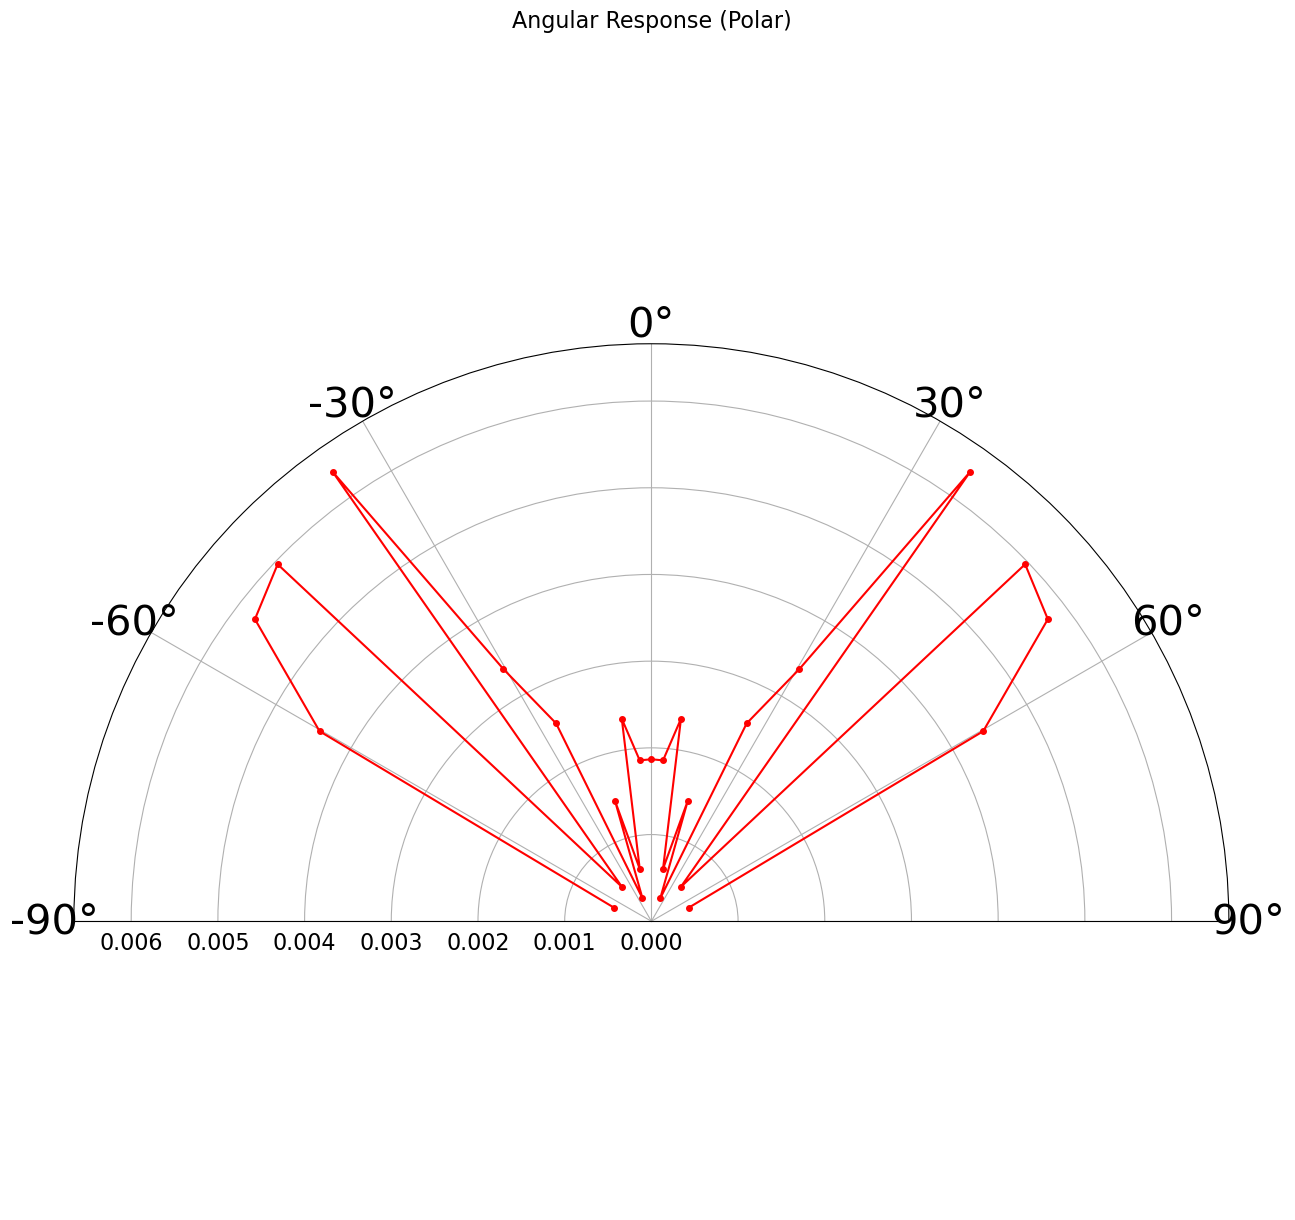

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# — 기존 연산(생략) — 
# dft_fields_Ez → E_k → kx → mask → kx_prop → theta_deg, amplitude_prop 계산

# (1) degrees → radians
theta_rad = np.radians(theta_deg)

# (2) Polar subplot 생성
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection':'polar'})

# (3) Plot
ax.plot(theta_rad, amplitude_prop, '-ro', markersize=4,)

# (4) 0° 위치와 방향 설정
#    0°를 위쪽(North)에, 각도는 오른쪽 방향(시계방향)으로 양(+) 증가하도록
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# (5) 표시할 각도 범위 한정: -90° … +90°
ax.set_thetalim(-np.pi/2, np.pi/2)

# (6) 눈금(xticks)도 -90° 간격으로
ax.set_xticks(np.radians([-90, -60, -30, 0, 30, 60, 90]))
ax.set_xticklabels(['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°'], fontsize = 30)
# ax.set_yticks(fontsize = font_label)
# (7) 스타일링
ax.set_rlabel_position(90)                 # radial label 위치
ax.set_title("Angular Response (Polar)",   fontsize=font_label, pad=20)
ax.grid(True)

# plt.tight_layout()
ax.tick_params(axis='y', labelsize=font_label)

plt.show()


In [39]:
dft_fields_Ez = sim[n_dipole-1].get_dft_array(dft_fields, mp.Ez, 0)

N = len(dft_fields_Ez)
dx = 1.0 / resolution       # (unit length 당 샘플링 간격)
k0 = 2 * np.pi * fcen       # (rad per unit length)

E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N    # shape = (N,)

# (2-2) “cycle per unit length” 단위의 x축 빈도 (shape = (N,))
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# (2-3) rad per unit length → kx 값
kx = 2 * np.pi * kx_cycles    # shape = (N,)

mask = np.abs(kx) <= k0      # k0보다 작은 것들은 evanescent mode로 분류
kx_prop = kx[mask]           # shape = (M,), M <= N

ky_prop = np.sqrt(np.maximum(k0**2 - kx_prop**2, 0.0))   # shape = (M,)

theta = np.arcsin(kx_prop / k0)      # radians
theta_deg = np.degrees(theta)       # degrees

amplitude = np.abs(E_k)              # shape = (N,)
amplitude_prop = amplitude[mask]**2     # 전파 가능 성분만 (shape = (M,))



In [124]:
n_dipole = 5
FourierFields = []

for i in range(n_dipole):
    FourierFields.append(mpa.FourierFields(sim[i],
                                           mp.Volume(center=mp.Vector3(0, center_y_sio2+tsio2/2+1/fcen),
                                                     size=mp.Vector3(dft_fields_size,0,0)),
                                                     mp.Ez,yee_grid=True))

ob_list = []

for i in range(n_dipole):
    ob_list.append(FourierFields[i])


In [125]:
def J(mode_amps):
    intensity = 0
    
    E = mode_amps[0]  # Ez 성분 추출
    N = len(E)
    E_k = npa.fft.fftshift(npa.fft.fft(E))
    kx = 2 * npa.pi * npa.fft.fftshift(npa.fft.fftfreq(N, d=1/resolution))
    k0 = 2 * npa.pi * fcen
    mask = npa.abs(kx) <= k0
    intensity += npa.mean(npa.abs(E_k[mask])**2)
    return intensity

opt = []
for i in range(n_dipole):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=[ob_list[i]],
        fcen=fcen,
        df=0,
        nf=1,
        design_regions=[design_region],
        decay_by=1e-1,
        ))


# 여기는 지금 당장 안해도 괜찮

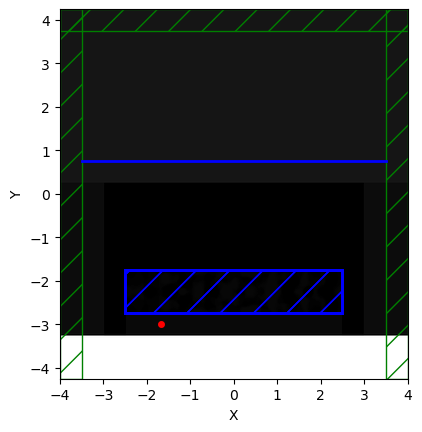

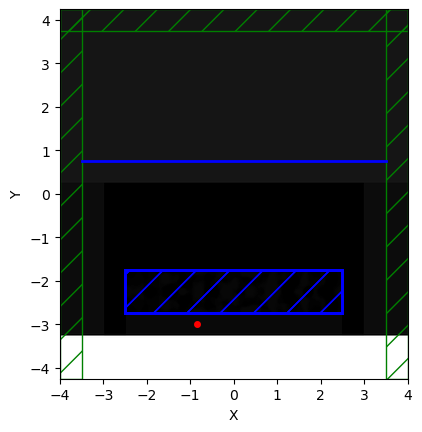

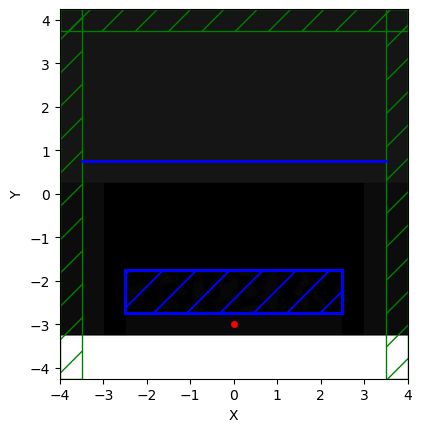

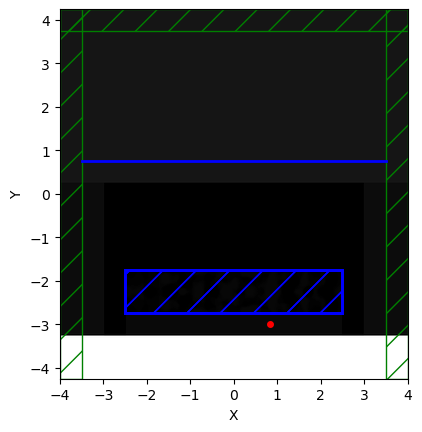

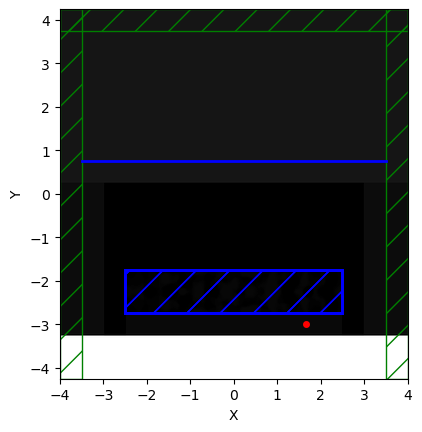

In [126]:
minimum_length = 0.09
eta_e = 0.55

filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e

def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.fliplr(projected_field) + projected_field
    ) / 2  # up-down symmetry

    # interpolate to actual materials
    return projected_field.flatten()

plt.figure()
x0 = mapping(
    np.random.rand(
        Nx * Ny,
    ),
    eta_i,
    128,
)

mp.verbosity(0)
for i in range(n_dipole): 
    opt[i].update_design([x0])
    opt[i].plot2D(True)
    plt.show()

# nlopt

In [135]:
evaluation_history = []
cur_iter = [0]
numevl = 0

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0 = []
    dJ_du = []

    global numevl

    for i in range(n_dipole):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)
        
        
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=0)
        )  # backprop

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(n_dipole)])

    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(n_dipole)]))

    return np.mean(f0)  # return the sum of the objective function values


In [136]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5

for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [0.25672124870014007, 0.24018477770866026, 0.24067284113692405, 0.2401847777086602, 0.2567212487001401]
Current f0 values: f0_0: [0.25672125], f0_1: [0.24018478], f0_2: [0.24067284], f0_3: [0.24018478], f0_4: [0.25672125]
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First

In [137]:
np.savetxt("lastdesign.txt", design_variables.weights)

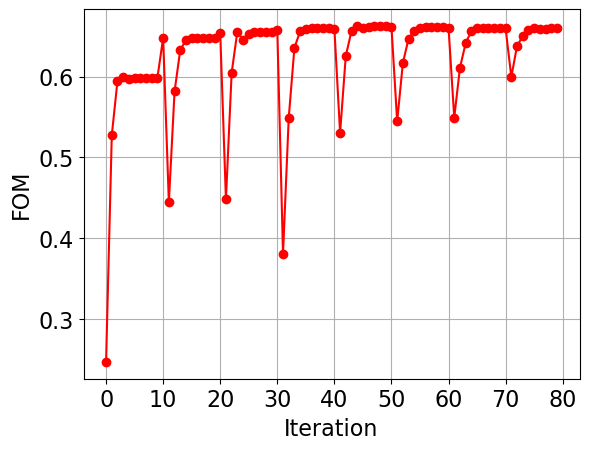

In [163]:
plt.figure()


plt.plot(np.mean(evaluation_history, axis =1), "or-")
plt.grid(True)
plt.xlabel("Iteration",  fontsize = font_label)
plt.ylabel("FOM", fontsize = font_label)
plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)
plt.show()


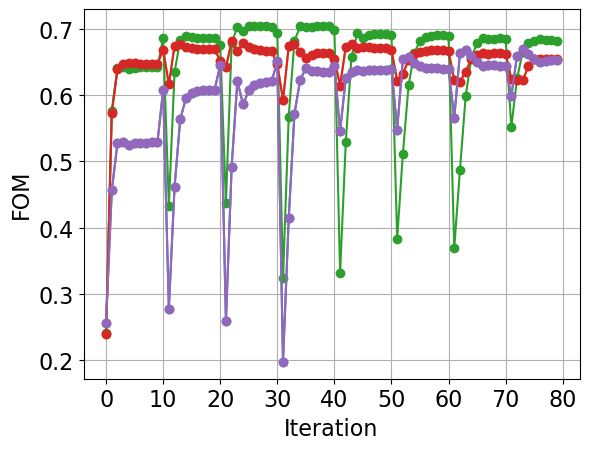

In [164]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration",  fontsize = font_label)
plt.ylabel("FOM", fontsize = font_label)
plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)
plt.show()

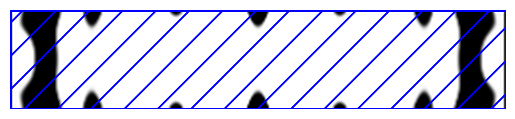

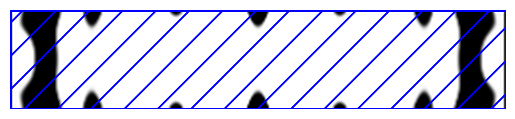

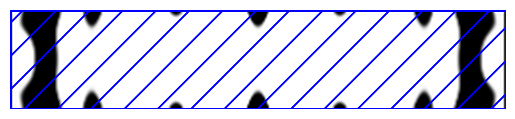

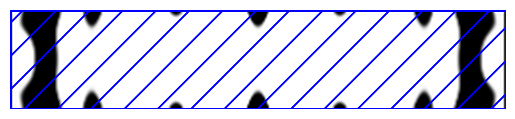

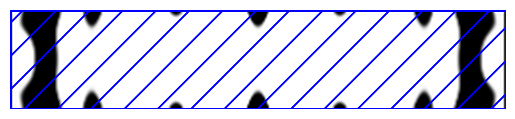

In [202]:
for i in range(n_dipole): 
    plt.figure()
    ax = plt.gca()
    opt[i].plot2D(
        True,
        output_plane = mp.Volume(size = design_region.size, center = design_region.center),
        # ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

In [324]:
opt_sim = []

sources = []
n_dipole=5

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

for i in range(n_dipole):
    # x: 디자인 영역 너비를 (i+1)/(n_dipole+1) 비율로 분할
    x_i = -design_region_width/2 + design_region_width * ((i+1) / (n_dipole+1))
    
    sources.append(
        mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                x_i,
                center_y_alq3,  # Alq3 층의 중간 높이
                0
            )
        )
    )

for i in range(n_dipole):
    opt[i].sim = mp.Simulation(
        cell_size=mp.Vector3(Sx, Sy),
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[sources[i]],
        default_material=air,
        resolution=resolution,
    )

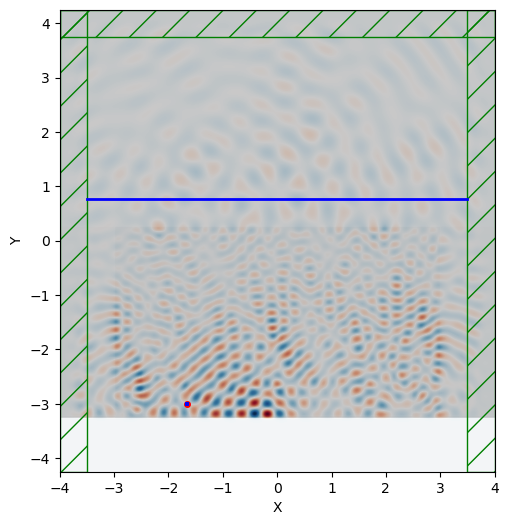

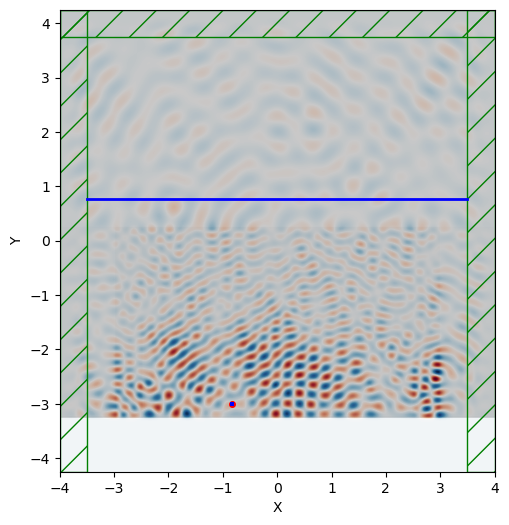

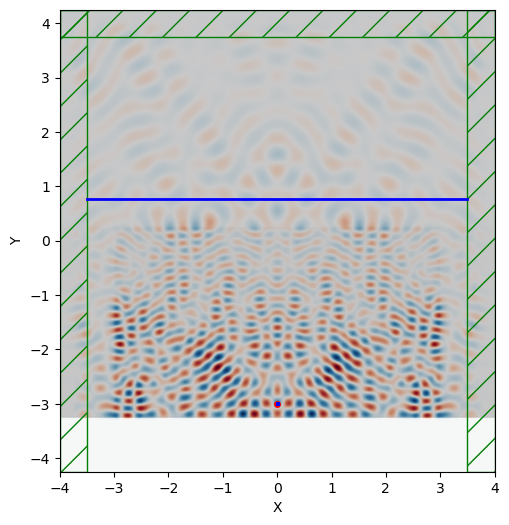

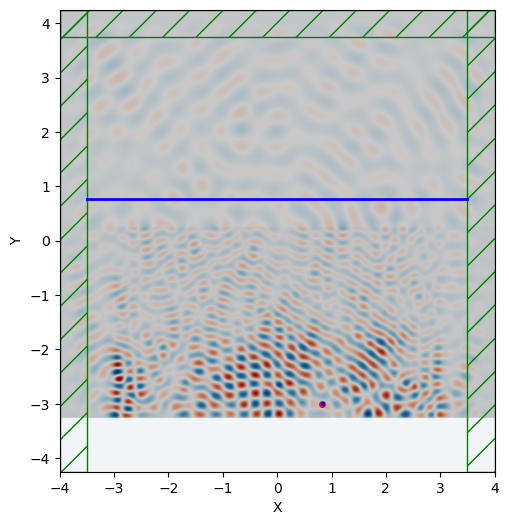

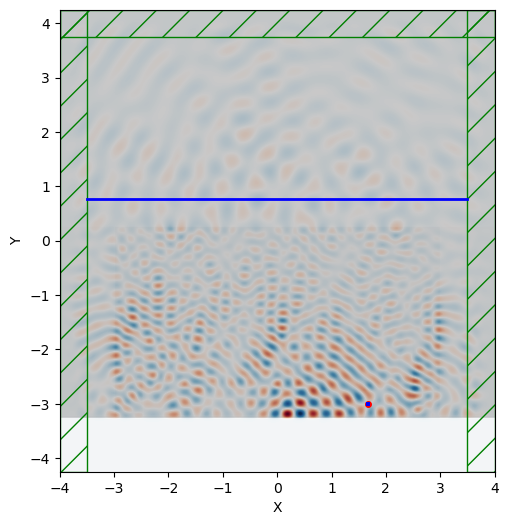

In [325]:
for i in range(n_dipole):
    
    dft_fields_size = tmetal_boundary+design_region_width+tmetal_boundary

    dft_fields = opt[i].sim.add_dft_fields([mp.Ez], fcen, 0, 1, 
                                    center = mp.Vector3(0, center_y_sio2+tsio2/2+1/fcen),
                                    size = mp.Vector3(dft_fields_size,0,0), 
                                    yee_gri=True)


    total_flux = opt[i].sim.add_flux(
    fcen, 0, 1,
    mp.FluxRegion(center=sources[i].center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=sources[i].center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=sources[i].center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=sources[i].center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
    )

    opt[i].sim.run(   mp.dft_ldos(fcen,0,1), until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources[i].center, tol))
    plt.figure(figsize=(6, 6))
    opt[i].sim.plot2D(fields=mp.Ez)

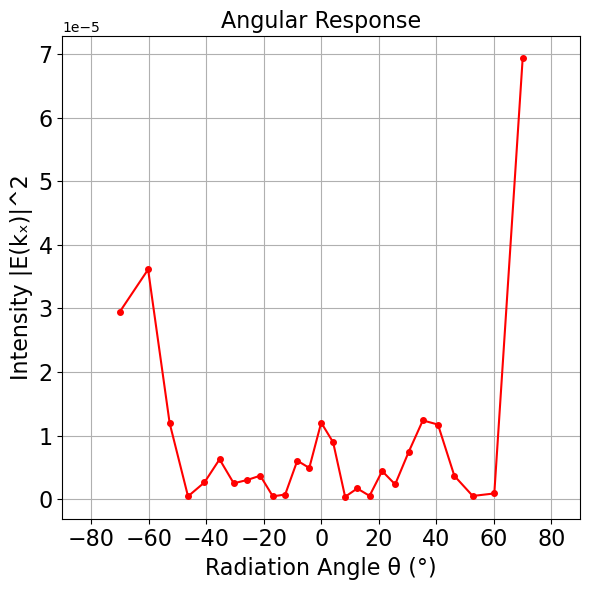

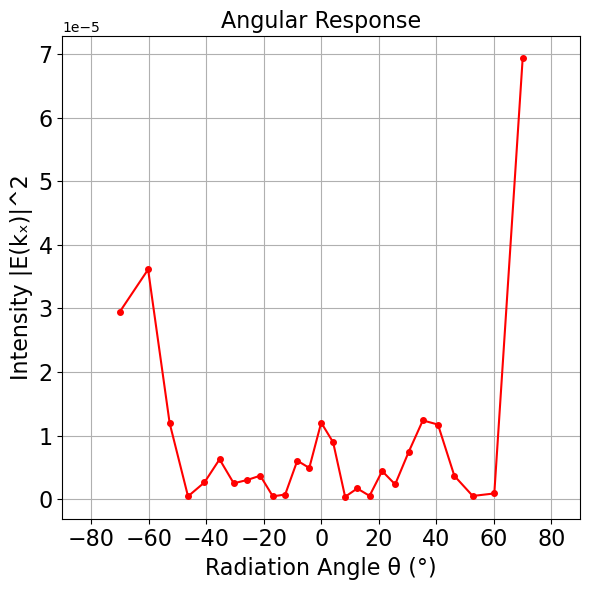

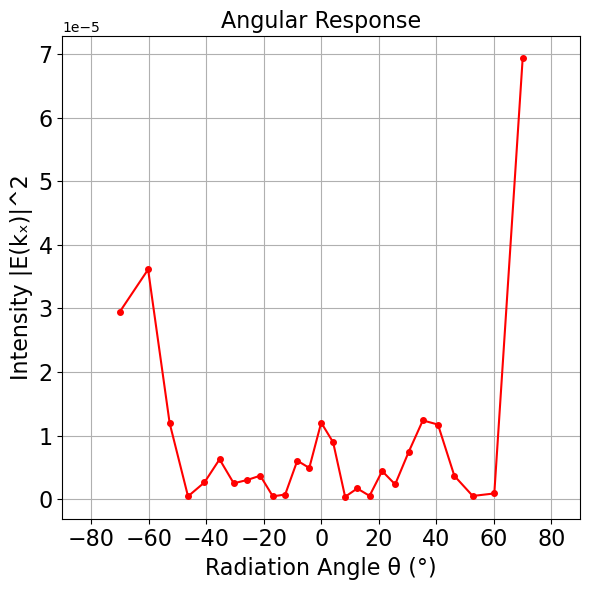

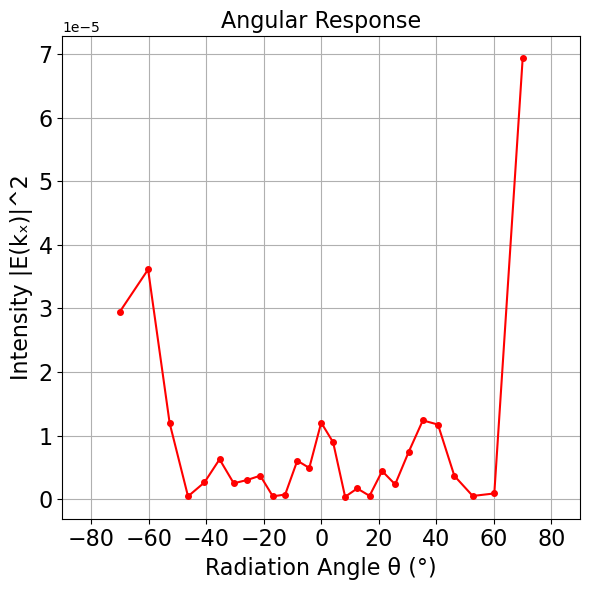

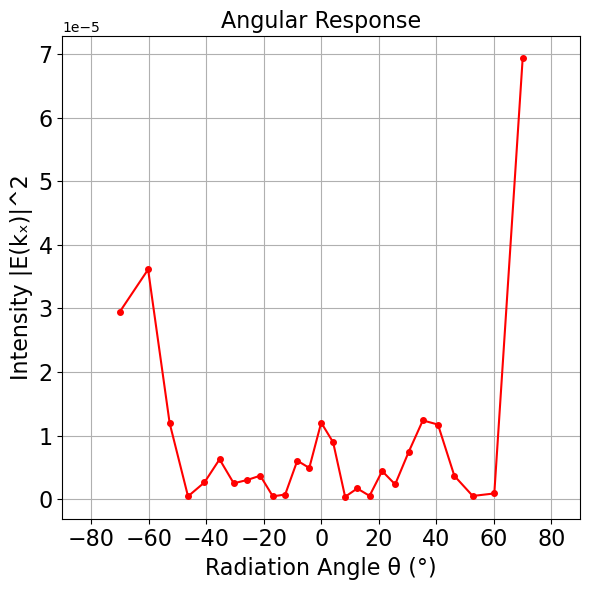

In [242]:
for i in range(n_dipole):      
    dft_fields_Ez = opt[i].sim.get_dft_array(dft_fields, mp.Ez, 0)

    N = len(dft_fields_Ez)
    dx = 1.0 / resolution       # (unit length 당 샘플링 간격)
    k0 = 2 * np.pi * fcen       # (rad per unit length)

    E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N    # shape = (N,)

    # (2-2) “cycle per unit length” 단위의 x축 빈도 (shape = (N,))
    kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

    # (2-3) rad per unit length → kx 값
    kx = 2 * np.pi * kx_cycles    # shape = (N,)

    mask = np.abs(kx) <= k0      # k0보다 작은 것들은 evanescent mode로 분류
    kx_prop = kx[mask]           # shape = (M,), M <= N

    ky_prop = np.sqrt(np.maximum(k0**2 - kx_prop**2, 0.0))   # shape = (M,)

    theta = np.arcsin(kx_prop / k0)      # radians
    theta_deg = np.degrees(theta)       # degrees

    amplitude = np.abs(E_k)              # shape = (N,)
    amplitude_prop = amplitude[mask]**2     # 전파 가능 성분만 (shape = (M,))

    font_label = 16

    plt.figure(figsize=(6, 6))
    plt.plot(theta_deg, amplitude_prop, '-ro', markersize=4)
    plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
    plt.ylabel("Intensity |E(kₓ)|^2",        fontsize=font_label)
    plt.title("Angular Response", fontsize=font_label)
    plt.xticks(fontsize = font_label)
    plt.yticks(fontsize = font_label)

    plt.grid(True)
    plt.xlim([-90, +90])   # θ ∈ [−90°, +90°] 범위
    plt.tight_layout()
    plt.show()

<Axes: xlabel='X', ylabel='Y'>

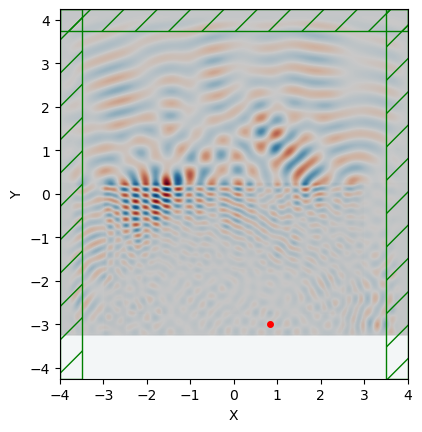

In [323]:
opt[3].sim.run(until=1)
opt[3].sim.plot2D(fields = mp.Ez)

In [326]:
dA = 1 / (resolution**2)

for i in range(n_dipole):
    ldos_total_flux = -np.real(opt[i].sim.ldos_Fdata[0] * np.conj(opt[i].sim.ldos_Jdata[0])) *dA

In [292]:
total = mp.get_fluxes(total_flux)

total

[2.386138306193557e-07]

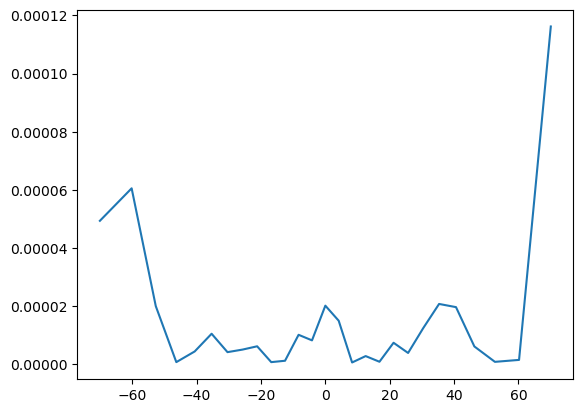

In [328]:
plt.plot(theta_deg, amplitude_prop / ldos_total_flux)